## Imports and Dataset Download

In [1]:
import os, pathlib, math, time, random
from dataclasses import dataclass
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
!pip install pytorch-msssim
from pytorch_msssim import ms_ssim

In [ ]:
#Download DIV2K dataset
import kagglehub
import glob
# Download latest version
path = kagglehub.dataset_download("soumikrakshit/div2k-high-resolution-images")
print("Path to dataset files:", path)
target_root = "/content/images"
target_sub  = os.path.join(target_root, "img")  # Where images are stored
os.makedirs(target_sub, exist_ok=True)
# Collect PNGs from DIV2k folders in dataset
src_patterns = [
    os.path.join(path, "DIV2K_train_HR", "DIV2K_train_HR", "*.png"),
    os.path.join(path, "DIV2K_valid_HR", "DIV2K_valid_HR", "*.png"),
    os.path.join(path, "*.png"),
]
png_files = []
for pat in src_patterns:
    png_files.extend(glob.glob(pat))
png_files = sorted(set(png_files))
print(f"Found {len(png_files)} PNGs")
random.seed(0)  # Same images every run
png_files = random.sample(png_files, k=min(400, len(png_files)))
print(f"Using {len(png_files)} PNGs after sampling")
# Copy images into /content/images/img and convert to RGB if needed
for i, src in enumerate(png_files, 1):
    dst = os.path.join(target_sub, os.path.basename(src))
    if not os.path.exists(dst):
        try:
            im = Image.open(src).convert("RGB")
            im.save(dst)
        except Exception as e:
            print("Skip:", src, "->", e)
    if i % 100 == 0:
        print(f"Copied {i}/{len(png_files)}")

print("Ready. Point cfg.data_root to:", target_root)

Using Colab cache for faster access to the 'div2k-high-resolution-images' dataset.
Path to dataset files: /kaggle/input/div2k-high-resolution-images
Found 900 PNGs
Using 400 PNGs after sampling
Copied 100/400
Copied 200/400
Copied 300/400
Copied 400/400
Ready. Point cfg.data_root to: /content/images


## Helper Methods

In [20]:
# Set all seeds for reproducibility
def set_seed(seed=42):
  random.seed(seed)  # Py seed
  np.random.seed(seed)   # NumPy seed
  torch.manual_seed(seed)  # Torch CPU Seed
  torch.cuda.manual_seed(seed)  # Torch GPU Seed
set_seed()

In [21]:
# Simple running avergae
class Avg:
  def __init__(self):
    self.n = self.s = 0 # Intialize number of values and their cumulative sum
  def add(self, v, k=1):
    self.s+=float(v)*k   # Adds value v to cumulative sum calc
    self.n+=k  # Add to count
  def avg(self):
    return self.s /max(1,self.n) # Running average

def psnr(mse):
  return 10.0*math.log10(1.0/max(1e-8,float(mse)))  # PSNR calc from MSE

In [14]:
# Experiment configuration
class CFG:
  data_root = "/content/images"  # Root directory for images
  crop_size = 256  # Train/validation image crop size
  batch_size = 16   # Global batch size
  num_workers = 2   # Dataloaders workers to speed up processing
  lr = 1e-4  # Adam optimizer learning rate
  max_steps = 2000  # Total training steps
  log_every = 200  # Logging interval
  checkpoint_dir = "/content/ckpts" # Checkpoint folder
  save_every = 1000   # Checkpoint interval
  lambda_rate = 0.01    # Weight for rate term
  latent_ch = 128    # Latent channels
  device = "cuda" if torch.cuda.is_available() else "cpu"  # Device
  amp = True   # Mixed precision flag

cfg = CFG()
pathlib.Path(cfg.checkpoint_dir).mkdir(parents=True, exist_ok=True)

In [5]:
## MS-SSIM loss function
from pytorch_msssim import ms_ssim # Ensure ms_ssim refers to the function here
!pip install lpips
import lpips

def ms_ssim_score_fn(x_hat, x):
  x_hat = torch.clamp(x_hat, 0.0, 1.0)  # Clamp range of x values
  x = torch.clamp(x, 0.0, 1.0)
  return ms_ssim(x_hat, x, data_range=1.0, size_average=True)   # Return similarity in [0,1]

# LPIPS loss function
# Initialize LPIPS model globally to avoid re-loading per call
lpips_vgg = lpips.LPIPS(net='vgg').to(cfg.device) # Use VGG as feature extractor

def lpips_score_fn(x_hat, x):
  x_hat = torch.clamp(x_hat, 0.0, 1.0)
  x = torch.clamp(x, 0.0, 1.0)
  return lpips_vgg(x_hat * 2 - 1, x * 2 - 1).mean() # LPIPS expects input in [-1, 1]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.4 MB/s eta 0:00:00
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 73.6MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


In [6]:
# Data pipeline
class Folder_Create(Dataset):
  def __init__(self, cfg:CFG, train=True):
    self.train = train    # Split flag
    self.cfg = cfg   # Keep cfg
    # Transforms: random for training, center for validation
    if train:
      tx = transforms.Compose([
          transforms.RandomResizedCrop(cfg.crop_size, scale=(0.6, 1.0)), # Random crop
          transforms.RandomHorizontalFlip(),                             # Random flipping
          transforms.ToTensor(), ])
    else:
      tx = transforms.Compose([
          transforms.Resize(cfg.crop_size),     # Resize to crop size
          transforms.CenterCrop(cfg.crop_size),    # Center crop
          transforms.ToTensor(), ])
    self.tx = tx   # Save transform
    root = pathlib.Path(cfg.data_root)   # Root directory initialized
    has_images = root.exists() and any(root.glob("*/*.*"))                # check data
    if has_images:
      base_ds  = torchvision.datasets.ImageFolder(cfg.data_root, transform=None)  # Load images w/o transform
      n = len(base_ds)
      rng = torch.Generator().manual_seed(0)   # Fixed split every run
      idx = torch.randperm(n, generator=rng)
      split = int(0.9 * n)   # 90% train, 10% val
      train_idx = idx[:split]
      val_idx   = idx[split:]
      if train:
        self.ds = torch.utils.data.Subset(base_ds, train_idx)  # Train dataset
      else:
        self.ds = torch.utils.data.Subset(base_ds, val_idx)   # Val dataset
    else:
      raise FileNotFoundError("No images in data root")

  def __len__(self):
    return len(self.ds) # Length of dataset

  def __getitem__(self, idx):
    img, _ = self.ds[idx]
    img = self.tx(img)  # Apply transform
    return img   # Get a single image

train_set = Folder_Create(cfg, train=True)    # Create training set
val_set = Folder_Create(cfg, train=False)   # Create validation set
train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, pin_memory=True, drop_last=True)  # Train loader
val_loader = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True, drop_last=False)   # Val loader
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

FileNotFoundError: No images in data root

In [22]:
# ResBlock Class: ResNet Block
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(ch, ch, 3, 1, 1), # 2D Convolutional Layer
            nn.ReLU(inplace=True),  # ReLU
            nn.Conv2d(ch, ch, 3, 1, 1),   # 2D Convolutional Layer
        )
    def forward(self, x):
        return x + self.net(x)

# Encoder Class: downsample via convolution to latent
class Encoder(nn.Module):
  def __init__(self, latent_ch=128):
    super().__init__()
    ch = 64   # Base channels
    self.net = nn.Sequential(
        nn.Conv2d(3, ch, 3, 2, 1),
        nn.ReLU(inplace=True),
        ResBlock(ch),
        nn.Conv2d(ch, 2*ch, 3, 2, 1),
        nn.ReLU(inplace=True),
        ResBlock(2*ch),
        nn.Conv2d(2*ch, latent_ch, 3, 2, 1),
        ResBlock(latent_ch)
    )
    '''
    self.net = nn.Sequential(
        nn.Conv2d(3, ch, 3, 2, 1),  # First conv layer: downsample by 2
        nn.ReLU(inplace=True),   # ReLU activation
        nn.Conv2d(ch, ch, 3, 1, 1), # Conv block 1: maintain channels and dim
        nn.ReLU(inplace=True),
        nn.Conv2d(ch, 2*ch, 3, 2, 1),  # Conv block 2: double channels and downsample by 2
        nn.ReLU(inplace=True),
        nn.Conv2d(2*ch, 2*ch, 3, 1, 1),   # Conv block 3: maintain channels and dim
        nn.ReLU(inplace=True),
        nn.Conv2d(2*ch, latent_ch, 3, 2, 1), )   # Output layer: reduce to latent channels and downsample by 2
    '''
  def forward(self,x):
    return self.net(x)  # Forward pass of model

# Decoder class: upsample from latent
class Decoder(nn.Module):
  def __init__(self, latent_ch=128):
    super().__init__()
    ch = 64
    self.net = nn.Sequential(
        nn.ConvTranspose2d(latent_ch, 2*ch, 4, 2, 1),  # upsample 1
        nn.ReLU(inplace=True),
        ResBlock(2*ch),                                # <-- add

        nn.ConvTranspose2d(2*ch, ch, 4, 2, 1),         # upsample 2
        nn.ReLU(inplace=True),
        ResBlock(ch),                                  # <-- add

        nn.ConvTranspose2d(ch, 3, 4, 2, 1),            # upsample 3
        nn.Sigmoid(),
    )
    '''
    self.net = nn.Sequential(
        nn.ConvTranspose2d(latent_ch, 2*ch, 4, 2, 1),  # First upsample: expand dim and reduce channels
        nn.ReLU(inplace=True),
        nn.Conv2d(2*ch, 2*ch, 3, 1, 1),  # Conv block 1: maintain channels and dim
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(2*ch, ch, 4, 2, 1),  # Second upsample: expand dim and reduce channels
        nn.ReLU(inplace=True),
        nn.Conv2d(ch, ch, 3, 1, 1),  # Conv block 2: maintain channels and dim
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(ch, 3, 4, 2, 1),  # Final upsample: expand to desired image size with 3 channels
        nn.Sigmoid(), )   # Keep output from [0,1]
    '''
  def forward(self,yhat):
    return self.net(yhat)  # Forward pass

## Factorized Prior and Hyperprior

In [39]:
import torch.optim.lr_scheduler

# Factorized Gaussian Prior
class FactorizedGaussianPrior(nn.Module):
  def __init__(self, latent_ch=128):
    super().__init__()
    self.net = nn.Sequential(
            nn.Conv2d(latent_ch, latent_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(latent_ch, latent_ch, 3, 1, 1),
            nn.Softplus()   # ensures positive
        )
    self.log_sigma = nn.Parameter(torch.zeros(latent_ch))  # Log sigma per channel
    self.register_buffer("const", torch.tensor(0.5*math.log(2*math.pi)))   # Register 0.5ln(2pi) as buffer
    self.register_buffer("log2e", torch.tensor(1.0/math.log(2.0)))   # Register 1/ln(2) as buffer

  def forward(self,y, img_size):
    H_img, W_img = img_size
    sigma = self.log_sigma.exp().view(1, -1, 1, 1)  # Broadcast sigma val
    logp = -self.const - torch.log(sigma) - (y**2) / (2.0 * sigma**2 + 1e-9)  # (N,sigma^2) per element
    bits = -(logp*self.log2e)    # Convert to bits
    N = y.shape[0]
    bpp = bits.sum()/(N*H_img*W_img)  # Bits per pixel
    return bpp

# Full model
class AEWithPrior(nn.Module):
  def __init__(self, latent_ch=128):
    super().__init__()
    self.encoder = Encoder(latent_ch)  # Encoder: analysis
    self.decoder = Decoder(latent_ch)  # Decoder: synthesis
    self.prior = FactorizedGaussianPrior(latent_ch)  # Prior: entropy model # Changed from FactorizedGaussianPrior to Hyperprior
    self.q_scale = nn.Parameter(torch.ones(1, latent_ch, 1, 1))  # Step size

  def forward(self, x, train_mode=True):
    y = self.encoder(x)  # Apply encoder and convert image to latent
    y_scaled = y / (self.q_scale + 1e-9)
    if train_mode:
      noise = torch.empty_like(y_scaled).uniform_(-0.5, 0.5)   # Uniform noise
      y_soft = y_scaled + noise # Apply noise to latent
      # hard path with STE (pretend round has gradient 1)
      y_hard = (torch.round(y_scaled) - y_scaled).detach() + y_scaled

      # decode both
      x_soft = self.decoder(y_soft * self.q_scale)
      x_hard = self.decoder(y_hard * self.q_scale)

      # you return both so loss can mix them
      return x_soft, x_hard, y_soft * self.q_scale, y_hard * self.q_scale
    else:
      y_q = torch.round(y_scaled)
      y_q = y_q * self.q_scale
      x_hat = self.decoder(y_q)   # Reconstruct image from latent
      H_img, W_img = x.shape[-2], x.shape[-1]  # Get image size
      bpp = self.prior(y_q, (H_img,W_img))   # Get bits per pixel/rate estimate
      return x_hat, bpp

model = AEWithPrior(latent_ch=cfg.latent_ch).to(cfg.device)          # Initialize model and move to device
ckpt = torch.load("/content/ae_step2000.pt", map_location=cfg.device)
model.load_state_dict(ckpt["model"])
opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)                # Adam optimizer
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=cfg.max_steps) # Cosine Annealing LR scheduler
scaler = torch.amp.GradScaler(enabled=cfg.amp)                  # AMP for speed

In [8]:
# Hyperprior
class Hyperprior(nn.Module):
    def __init__(self, latent_ch: int = 128, hyper_ch: int = 64, sigma_floor: float = 0.5):
        super().__init__()

        # Hyper-encoder: maps y -> z (same spatial size, fewer channels)
        self.hyper_enc = nn.Sequential(
            nn.Conv2d(latent_ch, hyper_ch, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hyper_ch, hyper_ch, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )   # Small 2 layer convolutional encoder

        # Hyper-decoder: maps z -> sigma_y (per-pixel, per-channel std for y)
        self.hyper_dec = nn.Sequential(
            nn.Conv2d(hyper_ch, latent_ch, kernel_size=3, stride=1, padding=1),
            nn.Softplus()  # Ensures sigma_y > 0
        )

        # Factorized Gaussian prior for z (one sigma per hyper channel)
        self.log_sigma_z = nn.Parameter(torch.zeros(hyper_ch))

        # Constants for Gaussian log-pdf in bits
        self.register_buffer("const", torch.tensor(0.5 * math.log(2 * math.pi)))
        self.register_buffer("log2e", torch.tensor(1.0 / math.log(2.0)))  # 1 / ln 2
        self.sigma_floor = sigma_floor

    def _gaussian_bits(self, x: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
        # Clamp sigma to avoid tiny stds that make pdf > 1
        sigma = torch.clamp(sigma, min=self.sigma_floor)
        logp = -self.const - torch.log(sigma) - (x ** 2) / (2.0 * sigma ** 2 + 1e-9)
        bits = -(logp * self.log2e)  # in bits
        return bits

    def forward(self, y: torch.Tensor, img_size):
        """
        y:        latent tensor (N, C, H_lat, W_lat)
        img_size: (H_img, W_img) of the original image, used for bpp normalization
        """
        N, C, H_lat, W_lat = y.shape
        H_img, W_img = img_size

        #  Hyper encoder: y -> z
        z = self.hyper_enc(y)  # (N, hyper_ch, H_lat, W_lat)

        #  Prior on z (factorized Gaussian)
        sigma_z = self.log_sigma_z.exp().view(1, -1, 1, 1)     # (1, hyper_ch, 1, 1)
        bits_z = self._gaussian_bits(z, sigma_z)  # in bits

        # Hyper decoder: z -> sigma_y
        sigma_y = self.hyper_dec(z)    # (N, C, H_lat, W_lat), >0
        bits_y = self._gaussian_bits(y, sigma_y)                    # in bits

        # Combine and normalize
        bits_total = bits_y.sum() + bits_z.sum()
        bpp = bits_total / (N * H_img * W_img)   # bits per image pixel

        return bpp
  # Full model
class AEWithPrior(nn.Module):
  def __init__(self, latent_ch=128):
    super().__init__()
    self.encoder = Encoder(latent_ch)  # Encoder: analysis
    self.decoder = Decoder(latent_ch)  # Decoder: synthesis
    self.prior = Hyperprior(latent_ch)  # Prior: entropy model
    self.q_scale = nn.Parameter(torch.ones(1, latent_ch, 1, 1))  # Step size

  def forward(self, x, train_mode=True):
    y = self.encoder(x)  # Apply encoder and convert image to latent
    y_scaled = y / (self.q_scale + 1e-9)
    if train_mode:
      noise = torch.empty_like(y_scaled).uniform_(-0.5, 0.5)   # Uniform noise
      y_soft = y_scaled + noise # Apply noise to latent
      # hard path with STE (pretend round has gradient 1)
      y_hard = (torch.round(y_scaled) - y_scaled).detach() + y_scaled

      # decode both
      x_soft = self.decoder(y_soft * self.q_scale)
      x_hard = self.decoder(y_hard * self.q_scale)

      # you return both so loss can mix them
      return x_soft, x_hard, y_soft * self.q_scale, y_hard * self.q_scale
    else:
      y_q = torch.round(y_scaled)
      y_q = y_q * self.q_scale
      x_hat = self.decoder(y_q)   # Reconstruct image from latent
      H_img, W_img = x.shape[-2], x.shape[-1]  # Get image size
      bpp = self.prior(y_q, (H_img,W_img))   # Get bits per pixel/rate estimate
      return x_hat, bpp

model = AEWithPrior(latent_ch=cfg.latent_ch).to(cfg.device)          # Initialize model and move to device
ckpt = torch.load("/content/ae_step2000.pt", map_location=cfg.device)
model.load_state_dict(ckpt["model"])
opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)                # Adam optimizer
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=cfg.max_steps) # Cosine Annealing LR scheduler
scaler = torch.amp.GradScaler(enabled=cfg.amp)                  # AMP for speed

## Training

In [ ]:
from pytorch_msssim import ms_ssim # Re-import ms_ssim to ensure it's a callable function
BETA = 0  # Vary this for MS-SSIM experiments
GAMMA = 0.03   # Vary this for LPIPS Loss
def train_step(batch):
  model.train()    # Training mode
  x = batch.to(cfg.device, non_blocking=True)  # Move to device
  with torch.amp.autocast(enabled=cfg.amp, device_type=cfg.device):  # AMP, mixed precision
    x_soft, x_hard, y_soft_quantized, y_hard_quantized_ste = model(x, train_mode=True)  # Forward pass
    alpha = 0.7   # 0.7 soft / 0.3 hard
    ms_mean = ms_ssim_score_fn(x_soft, x)

    mse_soft = F.mse_loss(x_soft, x)  # Calculate MSE loss/distortion term for soft quant
    mse_hard = F.mse_loss(x_hard, x)   # Calculate MSE loss/distortion term for hard quant
    mse = alpha * mse_soft + (1-alpha) * mse_hard

    lpips_val = lpips_score_fn(x_soft, x)

    distortion = mse + BETA * (1.0 - ms_mean) + GAMMA * lpips_val # Distortion term for training with MS-SSIM and LPIPS

    # Calculate BPP using the updated prior, passing the model's q_scale
    bpp = model.prior(y_soft_quantized, (x.shape[-2], x.shape[-1]))

    loss = cfg.lambda_rate*bpp+distortion   # Calculate rate-distortion with MS-SSIM
    #loss = cfg.lambda_rate*bpp+mse   # Calculate rate-distortion
  opt.zero_grad(set_to_none=True)   # Zero gradients
  scaler.scale(loss).backward()  # Backpropagation
  scaler.step(opt)  # Update weights
  scaler.update()   # Update AMP
  scheduler.step() # Update learning rate
  return float(loss), float(mse), float(bpp), float(ms_mean), float(lpips_val)

def val_step(batch):
  model.eval()   # Eval mode
  x = batch.to(cfg.device, non_blocking=True)  # Move to device
  x_hat, bpp = model(x, train_mode=False)  # Forward pass, bpp is now correctly calculated inside model.forward
  mse = F.mse_loss(x_hat, x)   # Calculate MSE loss/distortion term
  ms_score = ms_ssim_score_fn(x_hat, x)  # Calculate MS-SSIM loss/distortion term
  lpips_val = lpips_score_fn(x_hat, x)
  return float(mse), float(bpp), float(ms_score), float(lpips_val)

# Training loop
step = 0  # Change starting step based on what model checkpoint used
train_loss_avg = Avg()
train_mse_avg = Avg()
train_bpp_avg = Avg()
train_lpips_avg = Avg()
train_msssim_avg = Avg()
val_mse_avg = Avg()
val_bpp_avg = Avg()
val_msssim_avg = Avg()
val_lpips_avg = Avg()
t0 = time.time()
while step<cfg.max_steps:
  for batch in train_loader:
    loss, mse, bpp, ms_score, lpips_val = train_step(batch)  # Train model, renamed 'ms' to 'ms_score'
    train_loss_avg.add(loss)  # Add loss to running average
    train_mse_avg.add(mse)
    train_bpp_avg.add(bpp)
    train_msssim_avg.add(ms_score)
    train_lpips_avg.add(lpips_val)
    step+=1
    if step % 10 == 0:   # Periodically print results
      mse_avg = train_mse_avg.avg()
      ms_ssim_avg = train_msssim_avg.avg()
      lpips_avg = train_lpips_avg.avg()
      print(
              f"step={step:6d} | loss={train_loss_avg.avg():.4f} "
              f"| mse={mse_avg:.5f} | psnr={psnr(mse_avg):.2f} dB "
              f"| ms-ssim={ms_ssim_avg:.4f} "
              f"| bpp~{train_bpp_avg.avg():.3f} "
              f"| lr={opt.param_groups[0]['lr']:.6f}"
              f"| lpips={lpips_avg:.4f} "
            )
      train_loss_avg = Avg()
      train_mse_avg = Avg()
      train_bpp_avg = Avg()
      train_msssim_avg = Avg()
      train_lpips_avg = Avg()
    if step % cfg.save_every == 0 or step==cfg.max_steps:  # Save checkpoint
      torch.save(
                {"step": step, "model": model.state_dict(), "opt": opt.state_dict(), "scheduler": scheduler.state_dict()},
                os.path.join(cfg.checkpoint_dir, f"ae_step{step}.pt")
            )
    if step >= cfg.max_steps:
      break

# Validation loop
with torch.no_grad():
  for i, batch in enumerate(val_loader):
    m, r, s, l= val_step(batch)   # Evaluate on validation set
    val_mse_avg.add(m, k=len(batch))   # Weighted average of MSE
    val_bpp_avg.add(r, k=len(batch))   # Weighted average of BPP
    val_msssim_avg.add(s, k=len(batch))   # Weighted average of MS-SSIM
    val_lpips_avg.add(l, k=len(batch))
    if i>=10:
      break
print(
  f"Validation: mse={val_mse_avg.avg():.5f} "
  f"| psnr={psnr(val_mse_avg.avg()):.2f} dB "
  f"| bpp~={val_bpp_avg.avg():.3f} "
  f"| ms-ssim={val_msssim_avg.avg():.4f} "
  f"| lpips={val_lpips_avg.avg():.4f}"
)

step=    10 | loss=0.0226 | mse=0.00321 | psnr=24.94 dB | ms-ssim=0.9524 | bpp~1.102 | lr=0.000100| lpips=0.2788 
step=    20 | loss=0.0211 | mse=0.00218 | psnr=26.62 dB | ms-ssim=0.9561 | bpp~1.102 | lr=0.000100| lpips=0.2627 
step=    30 | loss=0.0204 | mse=0.00187 | psnr=27.29 dB | ms-ssim=0.9620 | bpp~1.103 | lr=0.000100| lpips=0.2487 
step=    40 | loss=0.0202 | mse=0.00193 | psnr=27.14 dB | ms-ssim=0.9613 | bpp~1.108 | lr=0.000100| lpips=0.2408 
step=    50 | loss=0.0200 | mse=0.00184 | psnr=27.35 dB | ms-ssim=0.9595 | bpp~1.107 | lr=0.000100| lpips=0.2349 
step=    60 | loss=0.0199 | mse=0.00182 | psnr=27.40 dB | ms-ssim=0.9621 | bpp~1.109 | lr=0.000100| lpips=0.2314 
step=    70 | loss=0.0199 | mse=0.00180 | psnr=27.45 dB | ms-ssim=0.9539 | bpp~1.109 | lr=0.000100| lpips=0.2322 
step=    80 | loss=0.0198 | mse=0.00188 | psnr=27.25 dB | ms-ssim=0.9580 | bpp~1.113 | lr=0.000100| lpips=0.2257 
step=    90 | loss=0.0196 | mse=0.00168 | psnr=27.74 dB | ms-ssim=0.9608 | bpp~1.109 | l

In [ ]:
with torch.no_grad():
    sigmas = model.prior.log_sigma.exp()
    print("sigma min/max:", sigmas.min().item(), sigmas.max().item())


AttributeError: 'Hyperprior' object has no attribute 'log_sigma'

## Evaluation

In [ ]:
import torchvision.utils as vutils
@torch.no_grad()
def save_preview():  # Save preview of batch of images
  batch = next(iter(val_loader)).to(cfg.device)   # Take a batch of images
  x = batch   # Original images

  # Original image details
  H_img, W_img = x.shape[-2], x.shape[-1]

  # Preview with hard quantization (train_mode=False)
  x_hat_hard, bpp_hard_val = model(x, train_mode=False)   # Decoded images and bpp with hard quantization
  bpp_hard = bpp_hard_val.item() # Get scalar bpp value

  mse_hard_batch = F.mse_loss(x_hat_hard, x) # Calculate batch MSE
  psnr_hard_batch = psnr(mse_hard_batch) # Calculate batch PSNR
  # Raw BPP calc, not estimated
  y = model.encoder(x)
  y_scaled = y / (model.q_scale + 1e-9)
  y_hard_scaled = torch.round(y_scaled)
  y_int = y_hard_scaled.cpu()
  if y_int.min() >= -32768 and y_int.max() <= 32767:
      bytes_per_val = 2  # Store as short
  else:
      bytes_per_val = 4   # Store as int
  raw_bits_hard = y_int.numel() * bytes_per_val * 8
  # Corrected Raw-Latent BPP calculation: divide by total original image pixels in the batch
  bpp_hard_raw = raw_bits_hard / (batch.shape[0] * H_img * W_img)
  print(f"Preview (Hard Quantization) PSNR: {psnr_hard_batch:.2f} dB | "
          f"Estimated BPP: {bpp_hard:.3f} | Raw-Latent BPP: {bpp_hard_raw:.3f}") # Print PSNR and BPP

  # Calculate per-image PSNR for hard quantization
  mse_per_image_hard = ((x_hat_hard - x)**2).mean(dim=[1,2,3])
  psnr_per_image_hard = 10.0 * torch.log10(1.0 / mse_per_image_hard)
  print("Per-image PSNR (Hard Quantization):")
  for i in range(batch.shape[0]):
      print(f"  Image {i+1}: {psnr_per_image_hard[i]:.2f} dB")

  grid_hard = torch.cat([x[:8], x_hat_hard[:8]], dim=0)  # Initialize grid
  out_hard = os.path.join(cfg.checkpoint_dir, "preview_original_reconstructed_hard.png")   # File path
  vutils.save_image(grid_hard, out_hard, nrow=8)  # Save image
  print("Saved preview (Hard Quantization) to ", out_hard)

  # Preview with soft quantization (train_mode=True)
  # model.forward for train_mode=True returns x_soft, x_hard, y_soft_quantized, y_hard_quantized_ste
  x_soft, x_hard_from_train, y_soft_quantized, y_hard_quantized = model(x, train_mode=True)   # Decoded images and scaled latents
  mse_soft_batch = F.mse_loss(x_soft, x) # Calculate batch MSE
  psnr_soft_batch = psnr(mse_soft_batch) # Calculate batch PSNR
  # Calculate bpp for soft quantization from y_soft_quantized, passing model.q_scale
  bpp_soft = model.prior(y_soft_quantized, (H_img, W_img))
  y_soft_int = torch.round(y_soft_quantized / model.q_scale).cpu() # Scale back to 1-step quantized values for raw bit calc
  if y_soft_int.min() >= -32768 and y_soft_int.max() <= 32767:
      bytes_per_val_soft = 2  # Store as short depending on values
  else:
      bytes_per_val_soft = 4   # Store as int
  raw_bits_soft = y_soft_int.numel() * bytes_per_val_soft * 8
  # Corrected Raw-Latent BPP calculation: divide by total original image pixels in the batch
  bpp_soft_raw = raw_bits_soft / (batch.shape[0] * H_img * W_img)
  print(f"Preview (Soft Quantization) PSNR: {psnr_soft_batch:.2f} dB | "
          f"Estimated BPP: {bpp_soft:.3f} | Raw-Latent BPP: {bpp_soft_raw:.3f}")

  # Calculate per-image PSNR for soft quantization
  mse_per_image_soft = ((x_soft - x)**2).mean(dim=[1,2,3])
  psnr_per_image_soft = 10.0 * torch.log10(1.0 / mse_per_image_soft)
  print("Per-image PSNR (Soft Quantization):")
  for i in range(batch.shape[0]):
      print(f"  Image {i+1}: {psnr_per_image_soft[i]:.2f} dB")

  grid_soft = torch.cat([x[:8], x_soft[:8]], dim=0)  # Initialize grid
  out_soft = os.path.join(cfg.checkpoint_dir, "preview_original_reconstructed_soft.png")   # File path
  vutils.save_image(grid_soft, out_soft, nrow=8)  # Save image
  print("Saved preview (Soft Quantization) to ", out_soft)

save_preview()

Preview (Hard Quantization) PSNR: 28.89 dB | Estimated BPP: 1.054 | Raw-Latent BPP: 32.000
Per-image PSNR (Hard Quantization):
  Image 1: 28.85 dB
  Image 2: 28.40 dB
  Image 3: 30.46 dB
  Image 4: 25.49 dB
  Image 5: 27.97 dB
  Image 6: 30.11 dB
  Image 7: 26.71 dB
  Image 8: 29.34 dB
  Image 9: 28.40 dB
  Image 10: 33.85 dB
  Image 11: 30.87 dB
  Image 12: 32.63 dB
  Image 13: 34.35 dB
  Image 14: 27.99 dB
  Image 15: 27.00 dB
  Image 16: 29.38 dB
Saved preview (Hard Quantization) to  /content/ckpts/preview_original_reconstructed_hard.png
Preview (Soft Quantization) PSNR: 29.00 dB | Estimated BPP: 1.093 | Raw-Latent BPP: 32.000
Per-image PSNR (Soft Quantization):
  Image 1: 28.98 dB
  Image 2: 28.50 dB
  Image 3: 30.62 dB
  Image 4: 25.57 dB
  Image 5: 28.02 dB
  Image 6: 30.28 dB
  Image 7: 26.79 dB
  Image 8: 29.44 dB
  Image 9: 28.52 dB
  Image 10: 34.10 dB
  Image 11: 31.00 dB
  Image 12: 32.82 dB
  Image 13: 34.63 dB
  Image 14: 28.09 dB
  Image 15: 27.10 dB
  Image 16: 29.49 dB

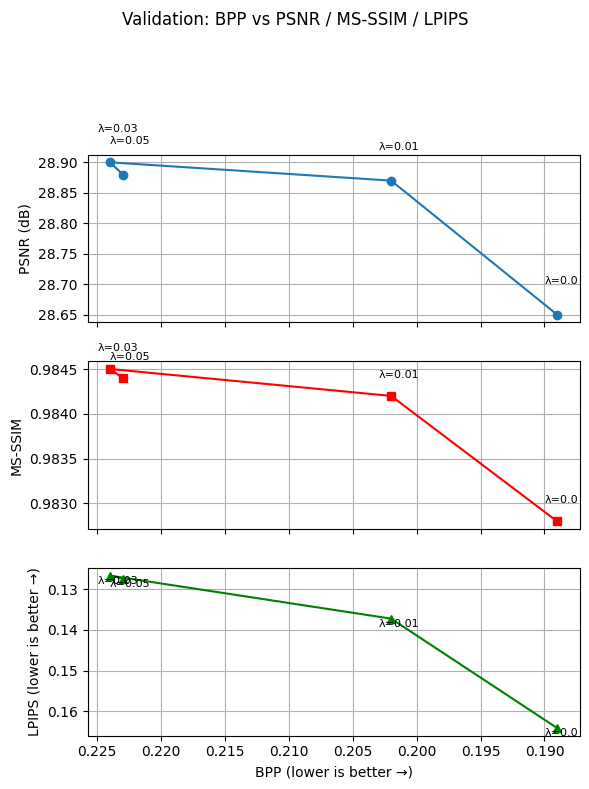

In [ ]:
import matplotlib.pyplot as plt

# ------ Validation data ------
# Validation metrics for beta sweep
bpp     = [0.189, 0.202, 0.224, 0.223]
psnrs   = [28.65, 28.87, 28.90, 28.88]
ms_ssim = [0.9828, 0.9842, 0.9845, 0.9844]
lpips   = [0.1642, 0.1372, 0.1266, 0.1273]
gammas  = [0.0, 0.01, 0.03, 0.05]

fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Validation: BPP vs PSNR / MS-SSIM / LPIPS', fontsize=12)

# --- 1) BPP vs PSNR ---
ax = axes[0]
ax.plot(bpp, psnrs, marker='o')
for x, y, lam in zip(bpp, psnrs, gammas):
    ax.text(x + 0.001, y + 0.05, f'λ={lam}', fontsize=8)
ax.set_ylabel('PSNR (dB)')
ax.grid(True)

# --- 2) BPP vs MS-SSIM ---
ax = axes[1]
ax.plot(bpp, ms_ssim, marker='s', color ='red')
for x, y, lam in zip(bpp, ms_ssim, gammas):
    ax.text(x + 0.001, y + 0.0002, f'λ={lam}', fontsize=8)
ax.set_ylabel('MS-SSIM')
ax.grid(True)

# --- 3) BPP vs LPIPS ---
ax = axes[2]
ax.plot(bpp, lpips, marker='^', color='green')
for x, y, lam in zip(bpp, lpips, gammas):
    ax.text(x + 0.001, y + 0.002, f'λ={lam}', fontsize=8)
ax.set_ylabel('LPIPS (lower is better →)')
ax.set_xlabel('BPP (lower is better →)')
ax.grid(True)

# ---- Flip x-axis (all) so right = lower BPP ----
for ax in axes:
    ax.invert_xaxis()

# ---- Flip LPIPS y-axis so up = lower LPIPS ----
axes[2].invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [ ]:
# Experiment statsitics: MSE, BPP, PSNR, LPIPS, MS-SSIM
import os, csv, math
import torch
import torch.nn.functional as F
from tqdm import tqdm
from pytorch_msssim import ms_ssim
# --- Fill these per run ---
EXP_NAME    = "exp1_mse_lambda0.01"   # e.g., "exp2_mse_lambda0.003"
LAMBDA_RATE = cfg.lambda_rate        # or set explicitly, e.g., 0.01
def psnr_from_mse(mse_val):
    return 10.0 * math.log10(1.0 / (mse_val + 1e-12))

@torch.no_grad()
def eval_hard(model, loader, device):
    model.eval()
    mse_sum = 0.0
    bpp_sum = 0.0
    ms_ssim_sum = 0.0
    lpips_sum = 0.0
    n_imgs = 0

    for batch in tqdm(loader, desc="Eval Hard", leave=False):
        x = batch.to(device)
        B = x.size(0)

        # model.forward for train_mode=False already returns correctly calculated bpp
        x_hat, bpp_val = model(x, train_mode=False)  # hard quant
        mse_batch = F.mse_loss(x_hat, x, reduction="none")  # [B,3,H,W]
        mse_per_img = mse_batch.mean(dim=(1,2,3))           # [B]
        ms_ssim_batch = ms_ssim_score_fn(x_hat, x) # MS-SSIM for batch
        lpips_batch = lpips_score_fn(x_hat, x)     # LPIPS for batch

        mse_sum += mse_per_img.sum().item()
        bpp_sum += bpp_val.item() * B # bpp is a scalar from the prior, multiply by batch size for weighted average
        ms_ssim_sum += ms_ssim_batch.item() * B
        lpips_sum += lpips_batch.item() * B
        n_imgs  += B

    mse_mean  = mse_sum / max(n_imgs, 1)
    bpp_mean  = bpp_sum / max(n_imgs, 1)
    ms_ssim_mean = ms_ssim_sum / max(n_imgs, 1)
    lpips_mean = lpips_sum / max(n_imgs, 1)
    psnr_mean = psnr_from_mse(mse_mean)

    return {"mse": mse_mean, "psnr": psnr_mean, "bpp": bpp_mean, "ms_ssim": ms_ssim_mean, "lpips": lpips_mean}

@torch.no_grad()
def hard_soft_gap(model, loader, device):
    model.eval()
    x = next(iter(loader)).to(device)

    # hard
    # model.forward for train_mode=False already returns correctly calculated bpp
    x_hard, bpp_hard_val = model(x, train_mode=False)
    mse_h = F.mse_loss(x_hard, x).item()
    psnr_h = psnr_from_mse(mse_h)
    ms_ssim_h = ms_ssim_score_fn(x_hard, x).item()
    lpips_h = lpips_score_fn(x_hard, x).item()
    bpp_hard = bpp_hard_val.item() # Get scalar bpp value

    # soft
    # model.forward for train_mode=True returns x_soft, x_hard, y_soft_quantized, y_hard_quantized_ste
    x_soft, x_hard_ste, y_soft_quantized, y_hard_quantized_ste = model(x, train_mode=True)
    mse_s = F.mse_loss(x_soft, x).item()
    psnr_s = psnr_from_mse(mse_s)
    ms_ssim_s = ms_ssim_score_fn(x_soft, x).item()
    lpips_s = lpips_score_fn(x_soft, x).item()

    H_img, W_img = x.shape[-2], x.shape[-1]
    # Calculate bpp for soft quantization, passing the model's q_scale
    bpp_s = model.prior(y_soft_quantized, (H_img, W_img)).item()

    return {
        "psnr_hard": psnr_h,
        "bpp_hard": bpp_hard,
        "ms_ssim_hard": ms_ssim_h,
        "lpips_hard": lpips_h,
        "psnr_soft": psnr_s,
        "bpp_soft": bpp_s,
        "ms_ssim_soft": ms_ssim_s,
        "lpips_soft": lpips_s,
        "psnr_gap": psnr_s - psnr_h,
        "bpp_gap": bpp_s - bpp_hard,
        "ms_ssim_gap": ms_ssim_s - ms_ssim_h,
        "lpips_gap": lpips_s - lpips_h
    }

# --- Run stats ---
train_stats = eval_hard(model, train_loader, cfg.device)
val_stats   = eval_hard(model, val_loader, cfg.device)
gap_stats   = hard_soft_gap(model, val_loader, cfg.device)

# --- Print summary ---
print("\n===== MSE SUMMARY =====")
print(f"Experiment: {EXP_NAME} | lambda={LAMBDA_RATE}")
print(f"TRAIN | PSNR={train_stats['psnr']:.2f} dB | BPP={train_stats['bpp']:.3f} | MSE={train_stats['mse']:.5f} | MS-SSIM={train_stats['ms_ssim']:.4f} | LPIPS={train_stats['lpips']:.4f}")
print(f"VAL   | PSNR={val_stats['psnr']:.2f} dB | BPP={val_stats['bpp']:.3f} | MSE={val_stats['mse']:.5f} | MS-SSIM={val_stats['ms_ssim']:.4f} | LPIPS={val_stats['lpips']:.4f}")

print("\n--- Hard vs Soft sanity (1 batch) ---")
print(f"Hard PSNR={gap_stats['psnr_hard']:.2f} dB | Hard BPP={gap_stats['bpp_hard']:.3f} | Hard MS-SSIM={gap_stats['ms_ssim_hard']:.4f} | Hard LPIPS={gap_stats['lpips_hard']:.4f}")
print(f"Soft PSNR={gap_stats['psnr_soft']:.2f} dB | Soft BPP={gap_stats['bpp_soft']:.3f} | Soft MS-SSIM={gap_stats['ms_ssim_soft']:.4f} | Soft LPIPS={gap_stats['lpips_soft']:.4f}")
print(f"Gaps      PSNR={gap_stats['psnr_gap']:.2f} dB | BPP={gap_stats['bpp_gap']:.3f} | MS-SSIM={gap_stats['ms_ssim_gap']:.4f} | LPIPS={gap_stats['lpips_gap']:.4f}")

# --- Append RD point to CSV ---
csv_path = os.path.join(cfg.checkpoint_dir, "rd_results_mse.csv")
new_file = not os.path.exists(csv_path)

with open(csv_path, "a", newline="") as f:
    writer = csv.writer(f)
    if new_file:
        writer.writerow([
            "experiment", "lambda",
            "train_psnr", "train_bpp", "train_mse", "train_ms_ssim", "train_lpips",
            "val_psnr", "val_bpp", "val_mse", "val_ms_ssim", "val_lpips",
            "hard_psnr", "hard_bpp", "hard_ms_ssim", "hard_lpips",
            "soft_psnr", "soft_bpp", "soft_ms_ssim", "soft_lpips",
            "psnr_gap", "bpp_gap", "ms_ssim_gap", "lpips_gap"
        ])
    writer.writerow([
        EXP_NAME, LAMBDA_RATE,
        train_stats["psnr"], train_stats["bpp"], train_stats["mse"], train_stats["ms_ssim"], train_stats["lpips"],
        val_stats["psnr"], val_stats["bpp"], val_stats["mse"], val_stats["ms_ssim"], val_stats["lpips"],
        gap_stats["psnr_hard"], gap_stats["bpp_hard"], gap_stats["ms_ssim_hard"], gap_stats["lpips_hard"],
        gap_stats["psnr_soft"], gap_stats["bpp_soft"], gap_stats["ms_ssim_soft"], gap_stats["lpips_soft"],
        gap_stats["psnr_gap"], gap_stats["bpp_gap"], gap_stats["ms_ssim_gap"], gap_stats["lpips_gap"]
    ])

print(f"\nAppended RD point to: {csv_path}")
print("===== DONE =====")



===== MSE SUMMARY =====
Experiment: exp1_mse_lambda0.01 | lambda=0.01
TRAIN | PSNR=28.44 dB | BPP=1.055 | MSE=0.00143 | MS-SSIM=0.9800 | LPIPS=0.1625
VAL   | PSNR=27.97 dB | BPP=1.063 | MSE=0.00160 | MS-SSIM=0.9793 | LPIPS=0.1636

--- Hard vs Soft sanity (1 batch) ---
Hard PSNR=28.89 dB | Hard BPP=1.054 | Hard MS-SSIM=0.9823 | Hard LPIPS=0.1491
Soft PSNR=28.99 dB | Soft BPP=1.093 | Soft MS-SSIM=0.9826 | Soft LPIPS=0.1502
Gaps      PSNR=0.10 dB | BPP=0.039 | MS-SSIM=0.0004 | LPIPS=0.0011

Appended RD point to: /content/ckpts/rd_results_mse.csv
===== DONE =====


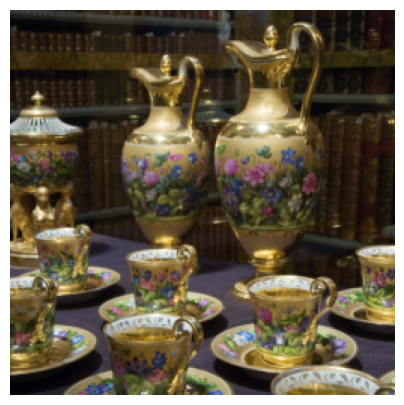

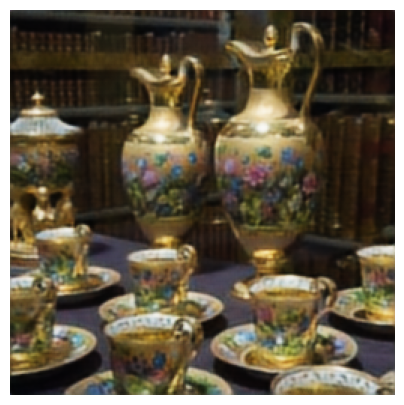

In [ ]:
import matplotlib.pyplot as plt
model.eval()

@torch.no_grad()
def display_separate_images():
    # Get a single image from the validation loader
    batch = next(iter(val_loader)).to(cfg.device)
    x = batch[0].unsqueeze(0) # Take the first image and add batch dimension

    # Original image details
    original_h, original_w = x.shape[-2], x.shape[-1]

    # Process with the model (hard quantization)
    x_hat, _ = model(x, train_mode=False)

    # Display Original Image
    plt.figure(figsize=(5, 5))
    plt.imshow(x.squeeze(0).cpu().permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

    # Display Reconstructed Image
    plt.figure(figsize=(5, 5))
    plt.imshow(x_hat.squeeze(0).cpu().permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

display_separate_images()

In [32]:
import kagglehub
# Download latest version
KODAK_DIR = kagglehub.dataset_download("drxinchengzhu/kodak24")
KODAK_DIR = os.path.join(KODAK_DIR, "images")
KODAK_DIR = os.path.join(KODAK_DIR, "train")
print("Path to dataset files:", KODAK_DIR)
image_paths = sorted(glob.glob(os.path.join(KODAK_DIR, "*.png")))
print(len(image_paths), "images found")
print(image_paths[:3])

Using Colab cache for faster access to the 'kodak24' dataset.
Path to dataset files: /kaggle/input/kodak24/images/train
24 images found
['/kaggle/input/kodak24/images/train/kodim01.png', '/kaggle/input/kodak24/images/train/kodim02.png', '/kaggle/input/kodak24/images/train/kodim03.png']


In [43]:
import os
import io
from PIL import Image
import torch
import torch.nn.functional as F
device = cfg.device
model.eval()
def pil_to_tensor(img: Image.Image) -> torch.Tensor:
    #Convert PIL image [H,W,3] to tensor [1,3,H,W] in [0,1]
    img = img.convert("RGB")
    x = torch.from_numpy(np.array(img)).float() / 255.0   # [H,W,3]
    x = x.permute(2, 0, 1).unsqueeze(0)                   # [1,3,H,W]
    return x

def tensor_to_pil(x: torch.Tensor) -> Image.Image:
    #Tensor [1,3,H,W] in [0,1] to PIL image
    x = x.detach().cpu().clamp(0, 1)
    x = (x[0].permute(1, 2, 0) * 255.0).round().byte().numpy()
    return Image.fromarray(x)

def compute_metrics(x_hat: torch.Tensor, x: torch.Tensor):
    #Return mse, psnr, ms-ssim, lpips as floats
    mse = F.mse_loss(x_hat, x).item()
    p = psnr(mse)
    ms = ms_ssim_score_fn(x_hat, x).item()
    lp = lpips_score_fn(x_hat, x).item()
    return mse, p, ms, lp

@torch.no_grad()
def eval_model_on_image(x: torch.Tensor):
    # x: tensor [1,3,H,W] in [0,1]
    # Returns: (bpp_est, mse, psnr, ms_ssim, lpips)
    x = x.to(device)
    x_hat, bpp = model(x, train_mode=False)   # bpp is the Gaussian proxy
    mse, p, ms, lp = compute_metrics(x_hat, x)
    return float(bpp), mse, p, ms, lp

def eval_codec_on_image(x: torch.Tensor, fmt: str = "JPEG", quality: int = 75):
    # x: tensor [1,3,H,W] in [0,1] (CPU).
    # fmt: "JPEG" or "WEBP"
    # quality: codec quality parameter
    # Returns: (bpp_real, mse, psnr, ms_ssim, lpips)
    orig_pil = tensor_to_pil(x)    # Original PIL
    buf = io.BytesIO()    # Compress to memory
    if fmt.upper() == "JPEG":
        orig_pil.save(buf, format="JPEG", quality=quality, subsampling=0, optimize=True)
    elif fmt.upper() == "WEBP":
        orig_pil.save(buf, format="WEBP", quality=quality, method=6)
    else:
        raise ValueError(f"Unknown format {fmt}")

    size_bytes = len(buf.getvalue())
    buf.seek(0)

    # Decompress image
    recon_pil = Image.open(buf).convert("RGB")
    x_hat = pil_to_tensor(recon_pil).to(device)  # Convert image to Tensor
    x_ref = x.to(device)

    # Bits-per-pixel (real) = file_size_bytes * 8 / (H*W)
    _, _, H, W = x.shape
    bpp_real = (size_bytes * 8.0) / (H * W)

    mse, p, ms, lp = compute_metrics(x_hat, x_ref)
    return bpp_real, mse, p, ms, lp

import glob

jpeg_quality = 25
webp_quality = 25

results_model = []   # Results for trained model
results_jpeg  = []   # Results for JPEG
results_webp  = []   # Results for WebP

with torch.no_grad():
    for img_path in sorted(glob.glob(os.path.join(KODAK_DIR, "*.png"))):
        img = Image.open(img_path)
        x = pil_to_tensor(img)  # [1,3,H,W]

        # Trained model calculations
        bpp_m, mse_m, psnr_m, ms_m, lp_m = eval_model_on_image(x)
        results_model.append((bpp_m, psnr_m, ms_m, lp_m))

        # JPEG calculations
        bpp_j, mse_j, psnr_j, ms_j, lp_j = eval_codec_on_image(x, fmt="JPEG", quality=jpeg_quality)
        results_jpeg.append((bpp_j, psnr_j, ms_j, lp_j))

        # WebP calculations
        bpp_w, mse_w, psnr_w, ms_w, lp_w = eval_codec_on_image(x, fmt="WEBP", quality=webp_quality)
        results_webp.append((bpp_w, psnr_w, ms_w, lp_w))

# Helper to average bpp, psnr, msssim, and lpips
def avg_stats(results):
    bpp = np.mean([r[0] for r in results])
    psn = np.mean([r[1] for r in results])
    mss = np.mean([r[2] for r in results])
    lps = np.mean([r[3] for r in results])
    return bpp, psn, mss, lps

bpp_m, psnr_m, ms_m, lp_m = avg_stats(results_model)
bpp_j, psnr_j, ms_j, lp_j = avg_stats(results_jpeg)
bpp_w, psnr_w, ms_w, lp_w = avg_stats(results_webp)

print("=== Kodak Averages ===")
print(f"Model : bpp~{bpp_m:.3f} (Gaussian proxy) | PSNR={psnr_m:.2f} dB | MS-SSIM={ms_m:.4f} | LPIPS={lp_m:.4f}")
print(f"JPEG  : bpp={bpp_j:.3f} (file)           | PSNR={psnr_j:.2f} dB | MS-SSIM={ms_j:.4f} | LPIPS={lp_j:.4f}")
print(f"WebP  : bpp={bpp_w:.3f} (file)           | PSNR={psnr_w:.2f} dB | MS-SSIM={ms_w:.4f} | LPIPS={lp_w:.4f}")


=== Kodak Averages ===
Model : bpp~0.204 (Gaussian proxy) | PSNR=30.57 dB | MS-SSIM=0.9833 | LPIPS=0.1705
JPEG  : bpp=0.611 (file)           | PSNR=30.28 dB | MS-SSIM=0.9608 | LPIPS=0.3131
WebP  : bpp=0.427 (file)           | PSNR=30.72 dB | MS-SSIM=0.9598 | LPIPS=0.3094


Model  bpp~0.188 | PSNR=32.90 dB | MS-SSIM=0.9863 | LPIPS=0.1789
JPEG  Q=10 | bpp=0.220 | PSNR=28.89 dB | MS-SSIM=0.8930 | LPIPS=0.5402
WebP  Q=20 | bpp=0.183 | PSNR=32.19 dB | MS-SSIM=0.9570 | LPIPS=0.3781


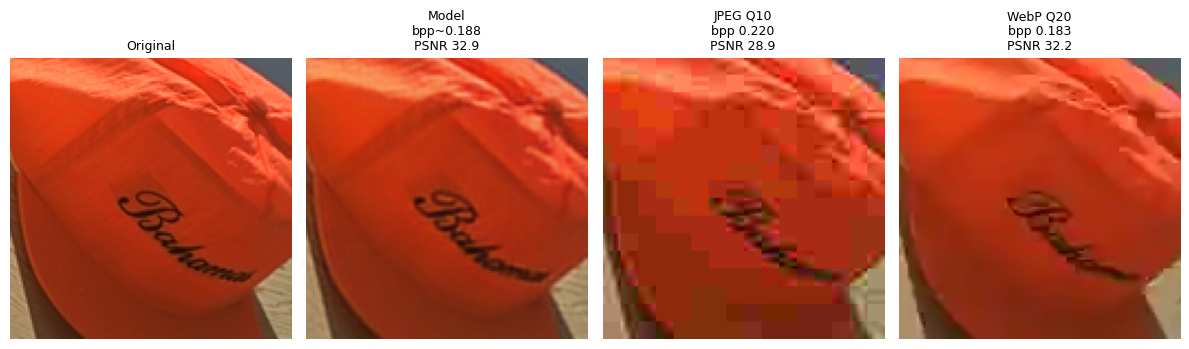

In [55]:
@torch.no_grad()
def compress_model(x: torch.Tensor):
    x = x.to(device)
    model.eval()
    x_hat, bpp = model(x, train_mode=False)  # Compute bpp
    mse, p, ms, lp = compute_metrics(x_hat, x) # Compure metrics
    return tensor_to_pil(x_hat), float(bpp), mse, p, ms, lp

def compress_codec(x: torch.Tensor, fmt: str = "JPEG", quality: int = 75):
    # x: tensor [1,3,H,W] in [0,1] (CPU).
    # fmt: "JPEG" or "WEBP"
    # quality: codec quality parameter
    # Returns: (bpp_real, mse, psnr, ms_ssim, lpips)
    orig_pil = tensor_to_pil(x)    # Original PIL
    buf = io.BytesIO()    # Compress to memory
    if fmt.upper() == "JPEG":
        orig_pil.save(buf, format="JPEG", quality=quality, subsampling=0, optimize=True)
    elif fmt.upper() == "WEBP":
        orig_pil.save(buf, format="WEBP", quality=quality, method=6)
    else:
        raise ValueError(f"Unknown format {fmt}")

    size_bytes = len(buf.getvalue())
    buf.seek(0)

    # Decompress image
    recon_pil = Image.open(buf).convert("RGB")
    x_hat = pil_to_tensor(recon_pil).to(device)  # Convert image to Tensor
    x_ref = x.to(device)

    # Bits-per-pixel (real) = file_size_bytes * 8 / (H*W)
    _, _, H, W = x.shape
    bpp_real = (size_bytes * 8.0) / (H * W)

    mse, p, ms, lp = compute_metrics(x_hat, x_ref)
    return recon_pil, bpp_real, mse, p, ms, lp

def find_best_quality_for_bpp(x, target_bpp, fmt, qual_list=None):
  # Find best quality for bpp
    if qual_list is None:
        qual_list = list(range(10, 101, 5))  # 10-100

    best = None
    best_diff = float("inf")

    for q in qual_list: # Iterate through each quality
        recon_pil, bpp, mse, p, ms, lp = compress_codec(x, fmt, q)  # Compress codec for each quality
        diff = abs(bpp - target_bpp)   # Difference between bpps
        if diff < best_diff:
            best_diff = diff
            best = (q, recon_pil, bpp, mse, p, ms, lp)

    return best  # (quality, recon_pil, bpp, mse, psnr, ms-ssim, lpips)

def center_crop(pil_img: Image.Image, crop_size: int = 128):
    # Center crop of size crop_size
    W, H = pil_img.size
    c = crop_size
    # Get edges of cropped image
    left = max(0, (W - c) // 2)
    top  = max(0, (H - c) // 2)
    right = min(W, left + c)
    bottom = min(H, top + c)
    return pil_img.crop((left, top, right, bottom)), (left, top, right, bottom)

def show_matched_bpp_crops(img_path, crop_size=128):
    # Load original image
    orig = Image.open(img_path).convert("RGB")
    x = pil_to_tensor(orig)  # [1,3,H,W]

    # Compress with  model
    model_recon_pil, bpp_model, mse_m, psnr_m, ms_m, lp_m = compress_model(x)
    print(f"Model  bpp~{bpp_model:.3f} | PSNR={psnr_m:.2f} dB | MS-SSIM={ms_m:.4f} | LPIPS={lp_m:.4f}")

    # Find JPEG and WebP qualities closest to model bpp
    q_jpeg, jpeg_recon_pil, bpp_j, mse_j, psnr_j, ms_j, lp_j = find_best_quality_for_bpp(
        x, bpp_model, fmt="JPEG"
    )
    q_webp, webp_recon_pil, bpp_w, mse_w, psnr_w, ms_w, lp_w = find_best_quality_for_bpp(
        x, bpp_model, fmt="WEBP"
    )

    print(f"JPEG  Q={q_jpeg} | bpp={bpp_j:.3f} | PSNR={psnr_j:.2f} dB | MS-SSIM={ms_j:.4f} | LPIPS={lp_j:.4f}")
    print(f"WebP  Q={q_webp} | bpp={bpp_w:.3f} | PSNR={psnr_w:.2f} dB | MS-SSIM={ms_w:.4f} | LPIPS={lp_w:.4f}")

    # Compute a common center crop box based on original
    orig_crop, box = center_crop(orig, crop_size=crop_size)
    model_crop = model_recon_pil.crop(box)
    jpeg_crop  = jpeg_recon_pil.crop(box)
    webp_crop  = webp_recon_pil.crop(box)

    # Plot crops side-by-side
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    imgs = [orig_crop, model_crop, jpeg_crop, webp_crop]
    titles = [
        "Original",
        f"Model\nbpp~{bpp_model:.3f}\nPSNR {psnr_m:.1f}",
        f"JPEG Q{q_jpeg}\nbpp {bpp_j:.3f}\nPSNR {psnr_j:.1f}",
        f"WebP Q{q_webp}\nbpp {bpp_w:.3f}\nPSNR {psnr_w:.1f}",
    ]

    for ax, im, title in zip(axes, imgs, titles):
        ax.imshow(im)
        ax.axis("off")
        ax.set_title(title, fontsize=9)

    plt.tight_layout()
    plt.show()

show_matched_bpp_crops(os.path.join(KODAK_DIR, "kodim03.png"), crop_size=128)



In [56]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Trainable parameters: {num_params:,} (~{num_params/1e6:.2f}M)")
import time
import torch

def measure_inference_time(model, device, img_size=256, iters=50):
    model.eval()
    # Dummy input: [1, 3, H, W]
    x = torch.rand(1, 3, img_size, img_size, device=device)

    # Warm-up runs (to avoid measuring startup overhead)
    with torch.no_grad():
        for _ in range(10):
            _ = model(x, train_mode=False)

    # Timed runs
    torch.cuda.empty_cache() if device == "cuda" else None
    if device == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    with torch.no_grad():
        for _ in range(iters):
            _ = model(x, train_mode=False)
        if device == "cuda":
            torch.cuda.synchronize()
    end = time.time()

    avg_time = (end - start) / iters
    print(f"Average encode+decode time for 1×3×{img_size}×{img_size}: {avg_time*1000:.2f} ms")

    return avg_time

avg_time = measure_inference_time(model, cfg.device, img_size=256, iters=50)


Trainable parameters: 1,948,355 (~1.95M)
Average encode+decode time for 1×3×256×256: 5.00 ms
